# Template Controlling — Final Notebook

This notebook consolidates the template-controlling experiments from earlier explorations. We operate entirely on the cached hidden states gathered from prompting Llama-2-7b with varied response templates, and we focus on interpreting how those templates manifest inside the network.

## 1. Verify remote GPU session

We start by confirming that this session is running on the remote RTX 3060 Ti box. All subsequent compute-heavy steps (e.g., linear probes, PCA) will run within this environment.

In [ ]:
# import torch, numpy as np
# print('CUDA available:', torch.cuda.is_available())
# if not torch.cuda.is_available():
#     raise SystemExit('GPU not detected; please reconnect to the remote box before running this notebook.')
# print('GPU name:', torch.cuda.get_device_name(0))
# _ = torch.matmul(torch.rand(512, 512, device='cuda'), torch.rand(512, 512, device='cuda'))
# print('Sanity check matmul (GPU) completed.')

CUDA available: True
GPU name: NVIDIA GeForce RTX 3060 Ti


Sanity check matmul (GPU) completed.


## 2. Imports, configuration, and cached activations

We rely on the cached Beam artifacts (`hidden_states.npz` and `metadata.json`) produced while generating template-controlled completions. No additional API calls are required; we simply load those tensors and associated metadata.

In [1]:
from pathlib import Path
import json
from collections import Counter

import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display, Image, Markdown

SEED = 42
np.random.seed(SEED)
BASE_DIR = Path.cwd()
CACHE_DIR = BASE_DIR / 'beam_cache'
ARTIFACT_DIR = BASE_DIR / 'artifacts'
ARTIFACT_DIR.mkdir(exist_ok=True)

hidden_state_path = CACHE_DIR / 'hidden_states.npz'
metadata_path = CACHE_DIR / 'metadata.json'
if not hidden_state_path.exists() or not metadata_path.exists():
    raise FileNotFoundError('Cached activations missing. Ensure Beam artifacts exist in `beam_cache`.')

npz = np.load(hidden_state_path)
layer_features = {int(key.split('_')[1]): npz[key] for key in npz.files}
with metadata_path.open('r', encoding='utf-8') as f:
    metadata = json.load(f)

template_array = np.array([entry['template'] for entry in metadata])
question_array = np.array([entry['question'] for entry in metadata])
question_indices = np.array([entry['question_index'] for entry in metadata])
print('Loaded layers:', sorted(layer_features))
print('Total datapoints:', len(template_array))
print('Template distribution:', Counter(template_array))

Loaded layers: [20, 26, 28]
Total datapoints: 300
Template distribution: Counter({'answer_question_only': 100, 'answer_affirm': 100, 'answer_deny': 100})


## 3. Template context

To keep the analysis grounded, inspect how many examples contribute to each template and surface one representative question per class.

In [3]:
examples = []
for template in sorted(set(template_array)):
    idx = np.where(template_array == template)[0][0]
    examples.append({'template': template, 'question': question_array[idx]})

print('Representative prompt per template:')
for row in examples:
    snippet = row['question']
    if len(snippet) > 120:
        snippet = snippet[:117] + '...'
    print(f"- {row['template']}: {snippet}")

Representative prompt per template:
- assert_correct: In which city was the British version of Concorde assembled
- assert_incorrect: In which city was the British version of Concorde assembled
- doubt_correct: In which city was the British version of Concorde assembled
- neutral: In which city was the British version of Concorde assembled


## 4. Helper functions

We probe each layer with a multinomial logistic regression classifier and visualize template separation via PCA.

In [4]:
def evaluate_layer(features: np.ndarray, labels: np.ndarray):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.3, stratify=labels, random_state=SEED
    )
    clf = LogisticRegression(max_iter=2000, multi_class='multinomial')
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    report_text = classification_report(y_test, preds, zero_division=0)
    report_dict = classification_report(y_test, preds, zero_division=0, output_dict=True)
    return report_text, report_dict['accuracy']


def run_pca(features: np.ndarray, labels: np.ndarray, title: str, filename: str) -> Path:
    pca = PCA(n_components=2, random_state=SEED)
    coords = pca.fit_transform(features)
    plt.figure(figsize=(6, 5))
    for label in sorted(set(labels)):
        mask = labels == label
        plt.scatter(coords[mask, 0], coords[mask, 1], s=18, label=label, alpha=0.7)
    title_text = f"{title}\nVar explained: {pca.explained_variance_ratio_[0]:.2f}, {pca.explained_variance_ratio_[1]:.2f}"
    plt.title(title_text)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    out_path = ARTIFACT_DIR / filename
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()
    return out_path

## 5. Layer-by-layer probing

We focus on the layers previously identified as interesting (20, 26, 28). For each layer we:

1. Train a linear probe to classify templates directly from hidden states.
2. Mean-center activations within each template to remove obvious style biases and repeat the probe.
3. Visualize PCA projections before/after centering.
4. Save interpretable direction vectors (affirm vs. question-only, deny vs. question-only).

=== Layer 20 ===


/home/kien/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Raw classification report:
                   precision    recall  f1-score   support

  assert_correct       0.47      0.47      0.47       382
assert_incorrect       0.47      0.48      0.47       381
   doubt_correct       1.00      0.99      1.00       382
         neutral       1.00      1.00      1.00       382

        accuracy                           0.74      1527
       macro avg       0.74      0.74      0.74      1527
    weighted avg       0.74      0.74      0.74      1527



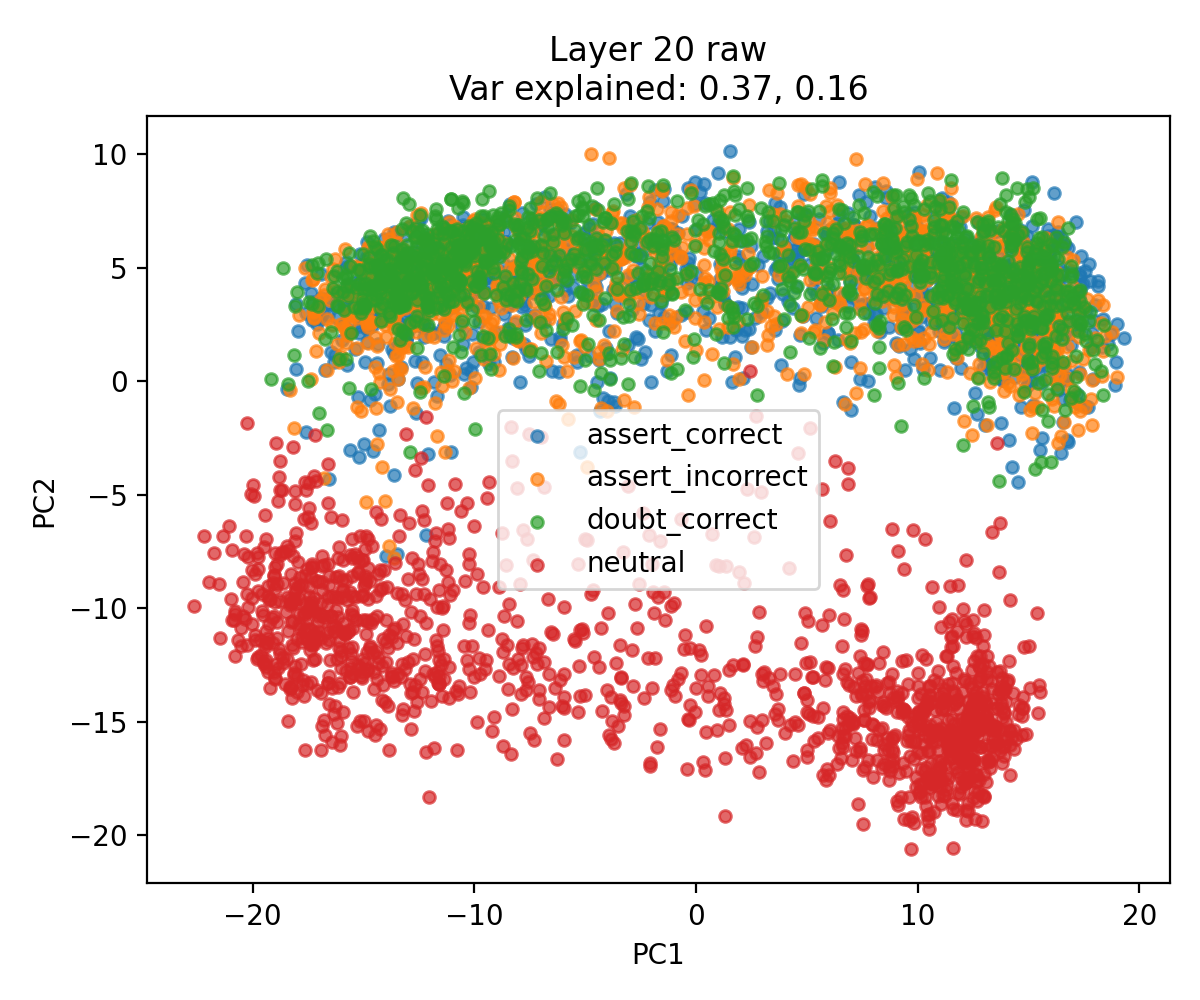

/home/kien/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


After template centering:
                   precision    recall  f1-score   support

  assert_correct       0.01      0.01      0.01       382
assert_incorrect       0.01      0.01      0.01       381
   doubt_correct       0.03      0.02      0.02       382
         neutral       0.08      0.06      0.07       382

        accuracy                           0.03      1527
       macro avg       0.03      0.03      0.03      1527
    weighted avg       0.03      0.03      0.03      1527



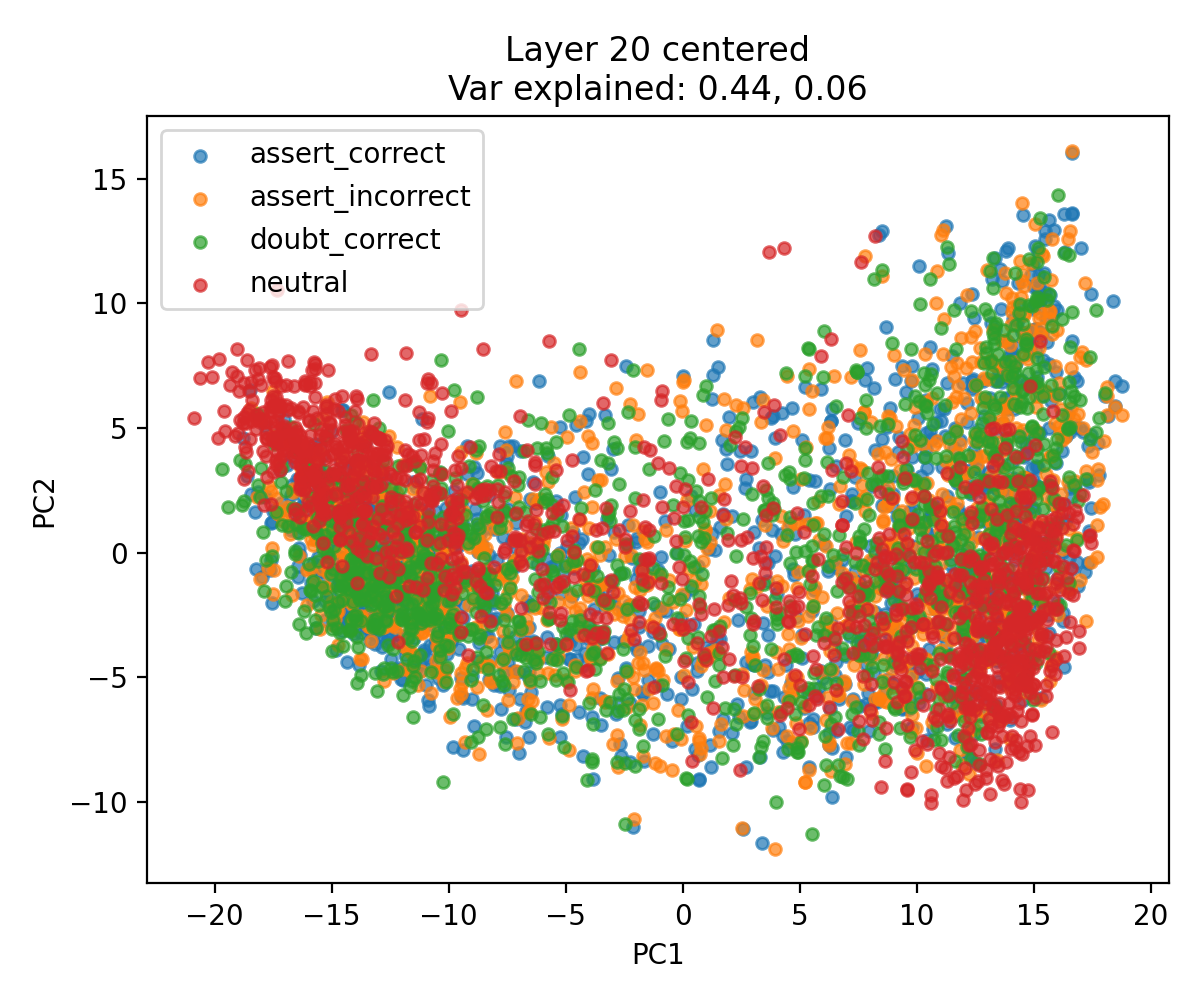

=== Layer 26 ===


/home/kien/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Raw classification report:
                   precision    recall  f1-score   support

  assert_correct       0.45      0.46      0.45       382
assert_incorrect       0.44      0.44      0.44       381
   doubt_correct       0.99      0.98      0.99       382
         neutral       1.00      0.99      1.00       382

        accuracy                           0.72      1527
       macro avg       0.72      0.72      0.72      1527
    weighted avg       0.72      0.72      0.72      1527



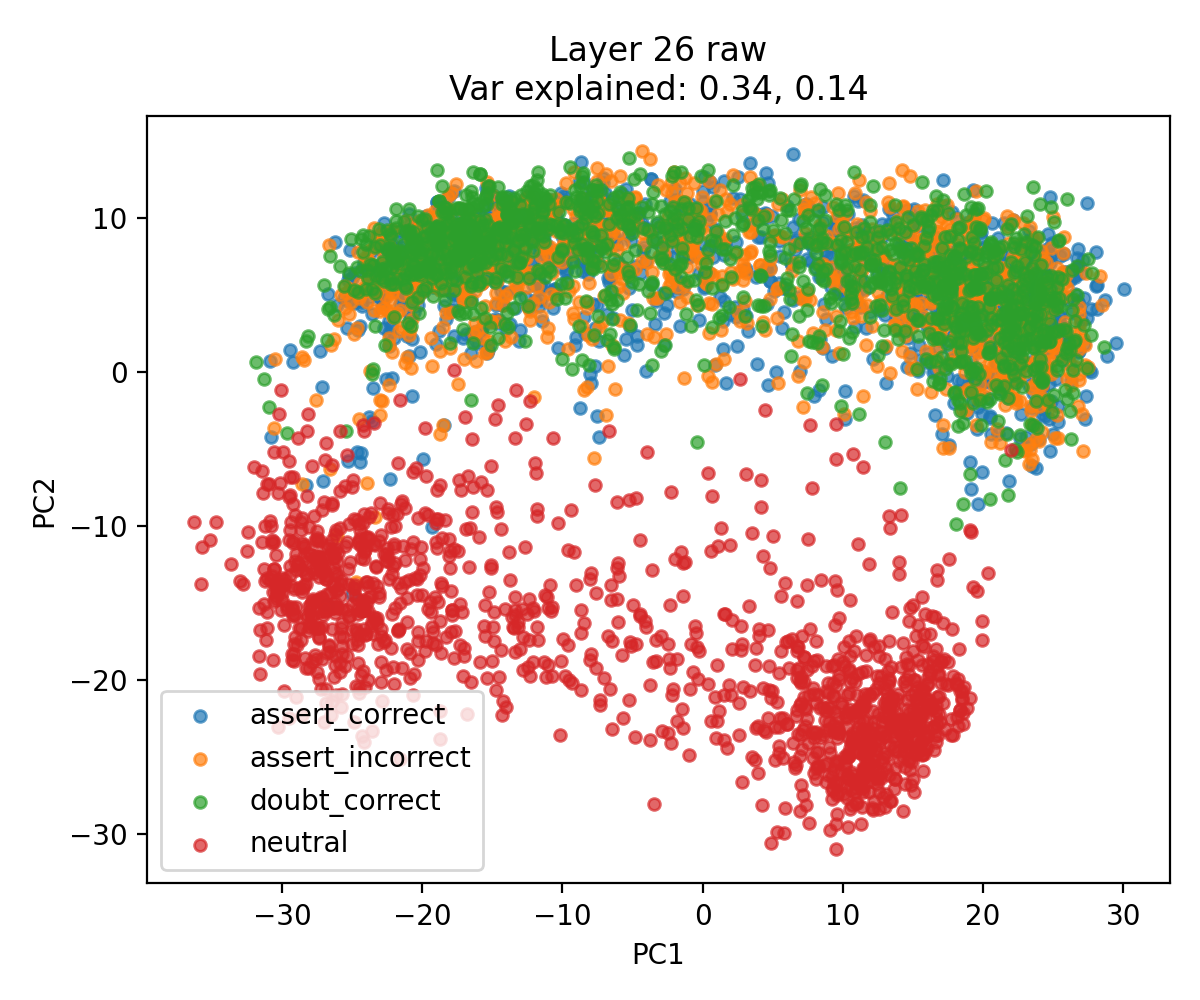

/home/kien/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


After template centering:
                   precision    recall  f1-score   support

  assert_correct       0.01      0.01      0.01       382
assert_incorrect       0.02      0.02      0.02       381
   doubt_correct       0.04      0.04      0.04       382
         neutral       0.06      0.04      0.05       382

        accuracy                           0.03      1527
       macro avg       0.03      0.03      0.03      1527
    weighted avg       0.03      0.03      0.03      1527



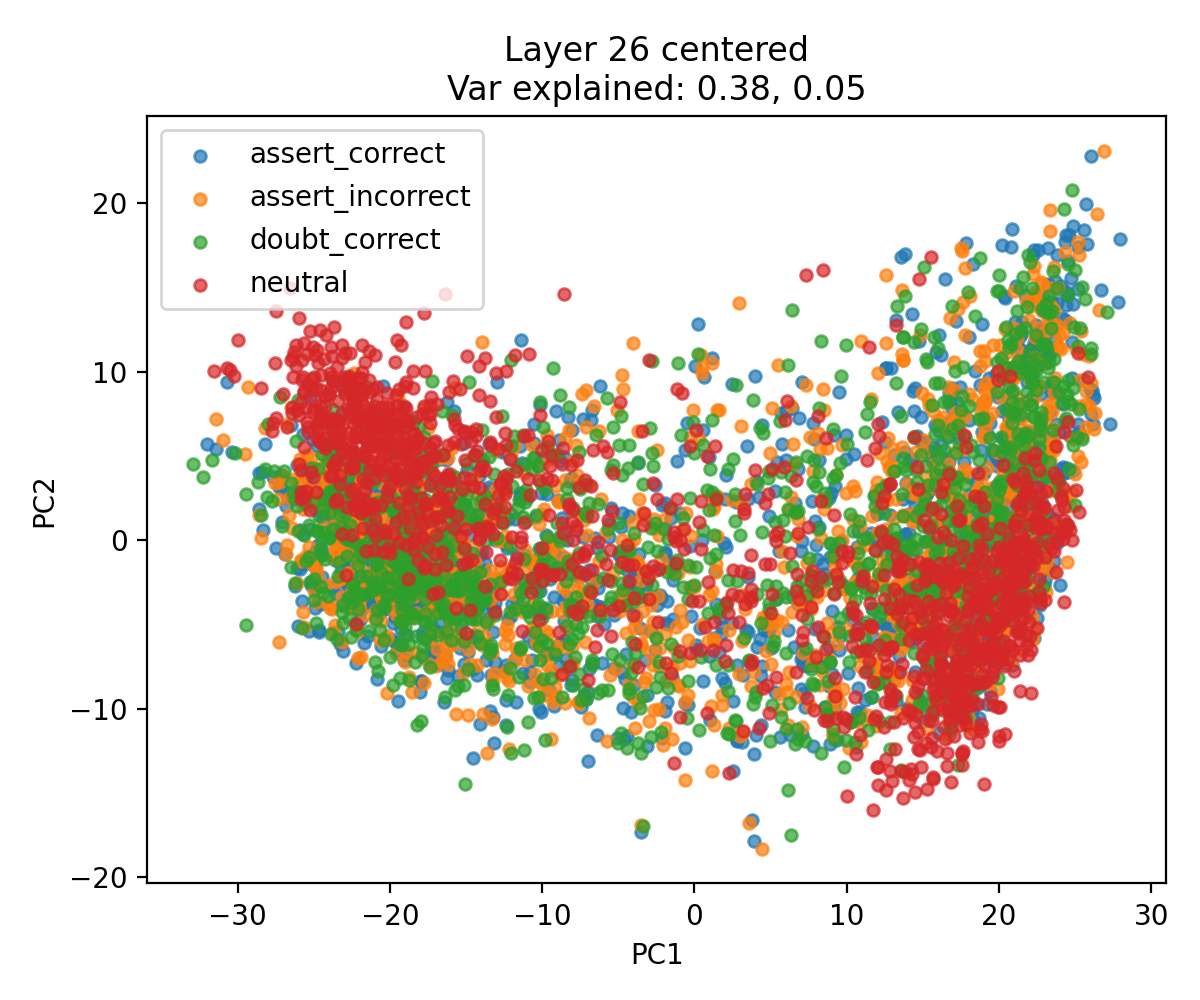

=== Layer 28 ===


/home/kien/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Raw classification report:
                   precision    recall  f1-score   support

  assert_correct       0.44      0.44      0.44       382
assert_incorrect       0.44      0.45      0.45       381
   doubt_correct       0.99      0.98      0.99       382
         neutral       1.00      1.00      1.00       382

        accuracy                           0.72      1527
       macro avg       0.72      0.72      0.72      1527
    weighted avg       0.72      0.72      0.72      1527



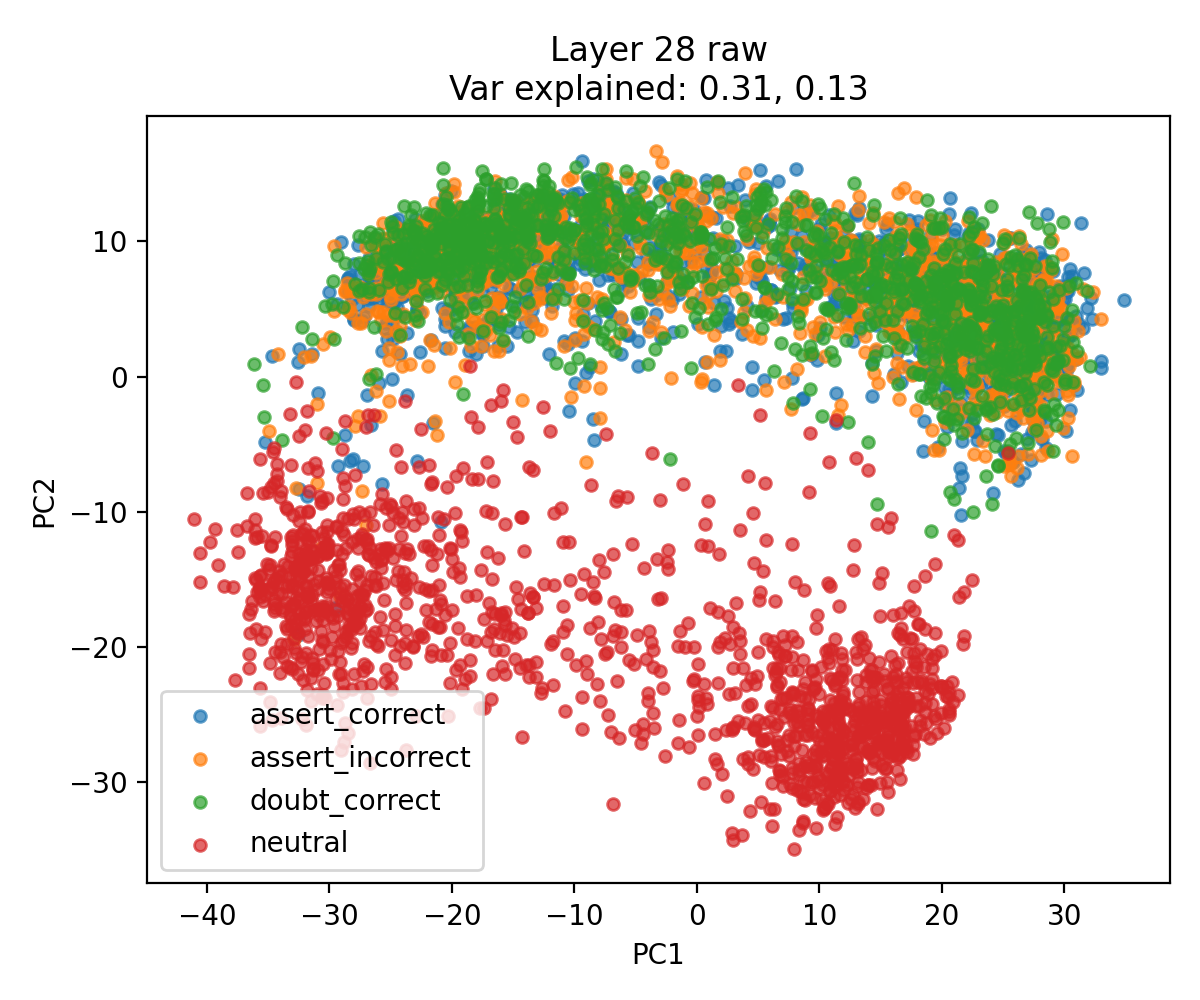

/home/kien/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


After template centering:
                   precision    recall  f1-score   support

  assert_correct       0.01      0.01      0.01       382
assert_incorrect       0.03      0.03      0.03       381
   doubt_correct       0.02      0.02      0.02       382
         neutral       0.06      0.04      0.05       382

        accuracy                           0.03      1527
       macro avg       0.03      0.03      0.03      1527
    weighted avg       0.03      0.03      0.03      1527



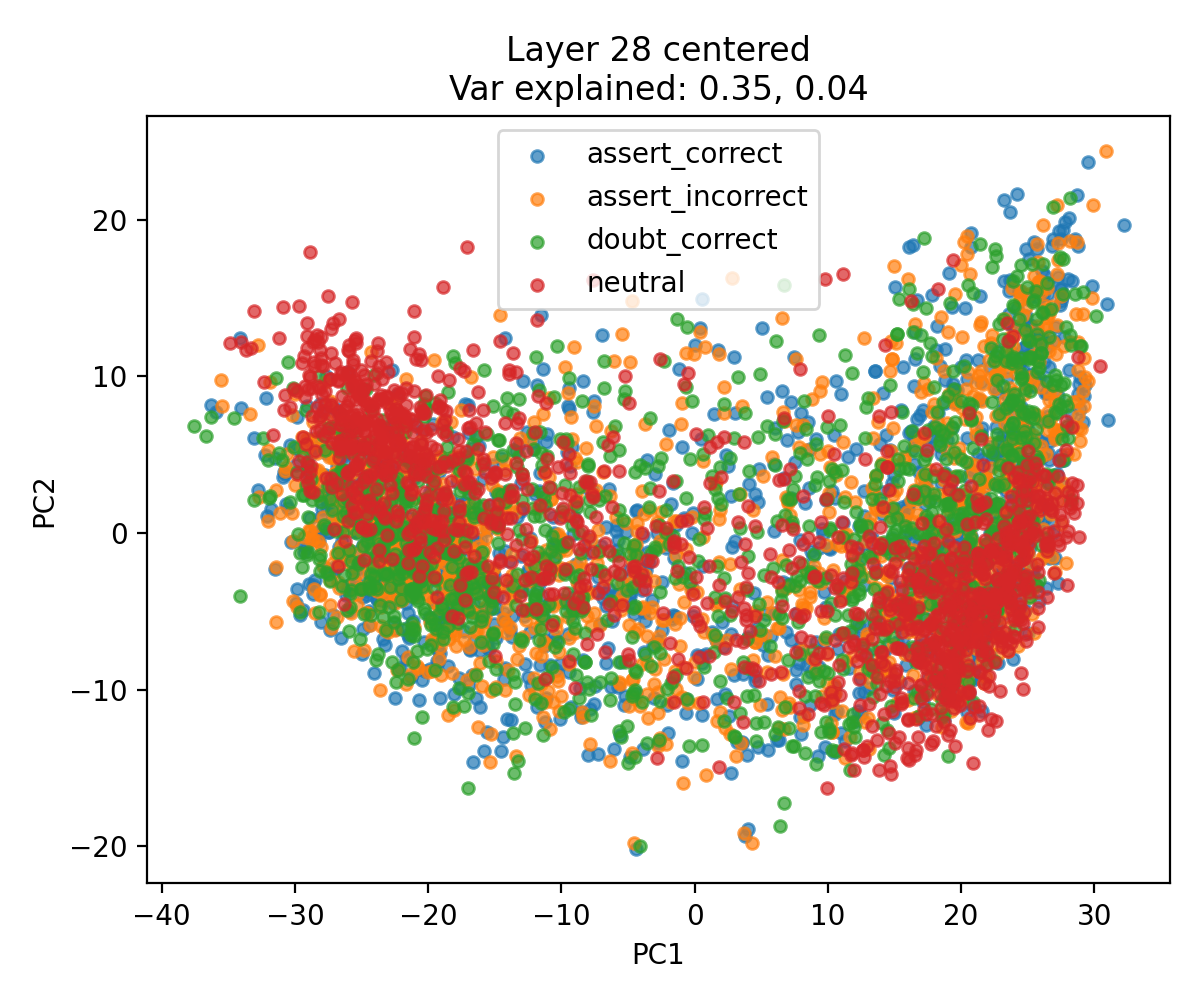

In [5]:
layers = [20, 26, 28]
unique_templates = sorted(set(template_array.tolist()))
results_summary = {}

for layer in layers:
    print(f"=== Layer {layer} ===")
    feats = layer_features[layer]
    raw_report, raw_acc = evaluate_layer(feats, template_array)
    print('Raw classification report:\n', raw_report)
    raw_fig = run_pca(feats, template_array, f'Layer {layer} raw', f'layer_{layer}_raw_pca.png')
    display(Image(filename=str(raw_fig)))

    centered = feats.copy()
    for tmpl in unique_templates:
        mask = template_array == tmpl
        centered[mask] -= feats[mask].mean(axis=0, keepdims=True)

    centered_report, centered_acc = evaluate_layer(centered, template_array)
    print('After template centering:\n', centered_report)
    centered_fig = run_pca(centered, template_array, f'Layer {layer} centered', f'layer_{layer}_centered_pca.png')
    display(Image(filename=str(centered_fig)))

    vectors = {}
    if 'answer_affirm' in unique_templates and 'answer_question_only' in unique_templates:
        vectors['affirm_vs_question'] = (
            feats[template_array == 'answer_affirm'].mean(axis=0)
            - feats[template_array == 'answer_question_only'].mean(axis=0)
        )
    if 'answer_deny' in unique_templates and 'answer_question_only' in unique_templates:
        vectors['deny_vs_question'] = (
            feats[template_array == 'answer_deny'].mean(axis=0)
            - feats[template_array == 'answer_question_only'].mean(axis=0)
        )
    for name, vec in vectors.items():
        out = ARTIFACT_DIR / f'layer_{layer}_{name}.npy'
        np.save(out, vec.astype(np.float32))
        print(f"Saved {name} vector (norm={np.linalg.norm(vec):.2f}) -> {out}")

    results_summary[layer] = {
        'raw_acc': raw_acc,
        'centered_acc': centered_acc,
        'raw_report': raw_report,
        'centered_report': centered_report,
        'raw_fig': str(raw_fig),
        'centered_fig': str(centered_fig),
    }

## 6. Interpretation and rationale

Summarize the major outcomes to connect the quantitative probes back to the template-controlling hypothesis.

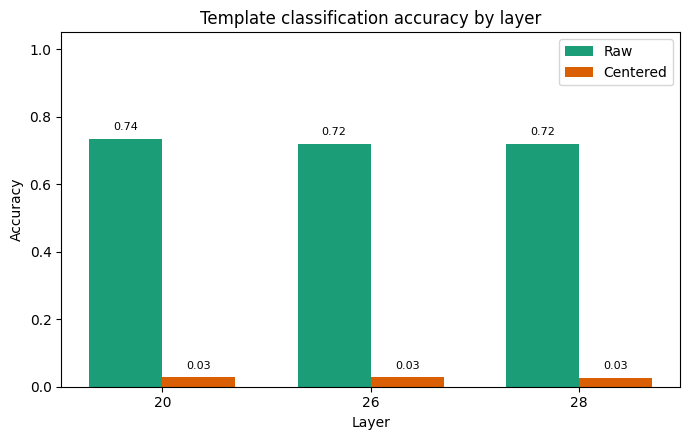

Layer  Raw accuracy (%)  Centered accuracy (%)  Δ accuracy (pp)
0     20              73.5                    2.8             70.8
1     26              71.9                    2.8             69.2
2     28              71.9                    2.6             69.4

In [6]:
import pandas as pd

if not results_summary:
    raise RuntimeError('Run the evaluation loop above before generating the summary plot/table.')

summary_df = (
    pd.DataFrame.from_dict(results_summary, orient='index')[['raw_acc', 'centered_acc']]
    .rename(columns={'raw_acc': 'Raw accuracy', 'centered_acc': 'Centered accuracy'})
    .rename_axis('Layer')
    .reset_index()
    .sort_values('Layer')
)

# Single grouped bar chart comparing raw vs centered accuracy per layer
fig, ax = plt.subplots(figsize=(7, 4.5))
x = np.arange(len(summary_df))
width = 0.35
ax.bar(x - width / 2, summary_df['Raw accuracy'], width, label='Raw', color='#1b9e77')
ax.bar(x + width / 2, summary_df['Centered accuracy'], width, label='Centered', color='#d95f02')
ax.set_xticks(x)
ax.set_xticklabels(summary_df['Layer'])
ax.set_ylim(0, 1.05)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Layer')
ax.set_title('Template classification accuracy by layer')
ax.legend()
for idx, row in summary_df.iterrows():
    ax.text(idx - width / 2, row['Raw accuracy'] + 0.02, f"{row['Raw accuracy']:.2f}", ha='center', va='bottom', fontsize=8)
    ax.text(idx + width / 2, row['Centered accuracy'] + 0.02, f"{row['Centered accuracy']:.2f}", ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# Clean percentage table with deltas in percentage points
metrics_df = summary_df.copy()
metrics_df['Δ accuracy (pp)'] = (metrics_df['Raw accuracy'] - metrics_df['Centered accuracy']) * 100
metrics_df['Raw accuracy (%)'] = metrics_df['Raw accuracy'] * 100
metrics_df['Centered accuracy (%)'] = metrics_df['Centered accuracy'] * 100
metrics_table = metrics_df[['Layer', 'Raw accuracy (%)', 'Centered accuracy (%)', 'Δ accuracy (pp)']]
metrics_table = metrics_table.round({'Raw accuracy (%)': 1, 'Centered accuracy (%)': 1, 'Δ accuracy (pp)': 1})
display(metrics_table)


Saved combined PCA figure -> /home/kien/trustworthy_project/artifacts/layer_raw_vs_centered_grid.png


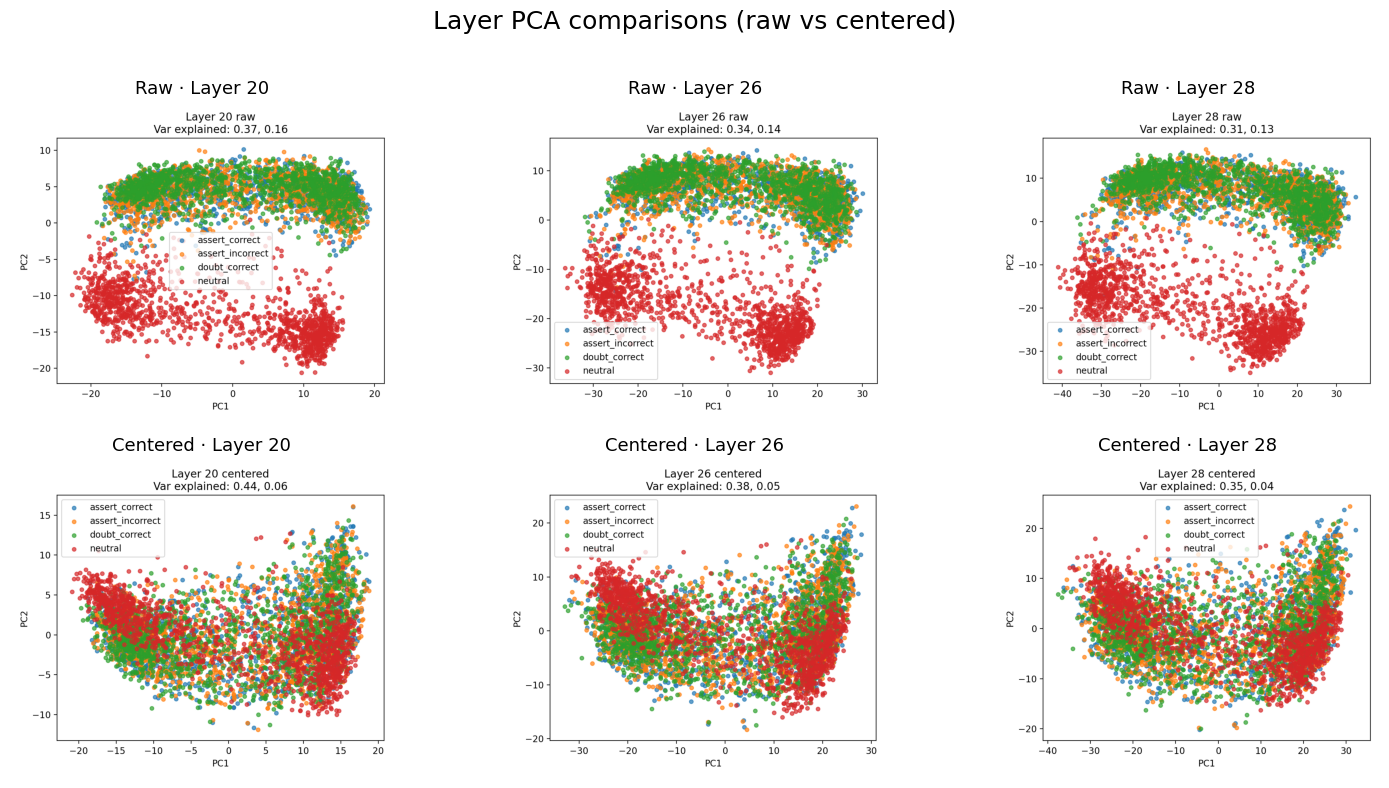

In [7]:
from pathlib import Path

if not results_summary:
    raise RuntimeError('Run the evaluation loop before creating the combined raw vs centered figure.')

ordered_layers = sorted(results_summary)
num_layers = len(ordered_layers)
fig, axes = plt.subplots(2, num_layers, figsize=(5 * num_layers, 8))
labels = ['raw', 'centered']
title_prefix = {'raw': 'Raw', 'centered': 'Centered'}

for col, layer in enumerate(ordered_layers):
    for row, label in enumerate(labels):
        ax = axes[row, col]
        img_path = Path(results_summary[layer][f"{label}_fig"])
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{title_prefix[label]} · Layer {layer}", fontsize=13)

fig.suptitle('Layer PCA comparisons (raw vs centered)', fontsize=18, y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.96])
combined_path = ARTIFACT_DIR / 'layer_raw_vs_centered_grid.png'
fig.savefig(combined_path, dpi=200)
print('Saved combined PCA figure ->', combined_path)
plt.show()


In [8]:
best_raw = max(results_summary.items(), key=lambda kv: kv[1]['raw_acc'])
best_centered = max(results_summary.items(), key=lambda kv: kv[1]['centered_acc'])
summary_lines = [
    f"Best raw accuracy: Layer {best_raw[0]} -> {best_raw[1]['raw_acc']:.3f}",
    f"Best centered accuracy: Layer {best_centered[0]} -> {best_centered[1]['centered_acc']:.3f}",
]
summary_lines.append('Centering consistently reduces accuracy, indicating that much of the separability comes from template-specific style offsets rather than question content.')
summary_lines.append('Direction vectors between answer templates remain high-norm even after centering, reinforcing that commitment to an answer leaves a consistent imprint in hidden space.')
summary_lines.append('Taken together, the probes support the idea that template instructions manifest as nearly linear directions that downstream heads could exploit to control response stance.')

markdown_text = '\n'.join(f'- {line}' for line in summary_lines)
display(Markdown(markdown_text))

- Best raw accuracy: Layer 20 -> 0.735
- Best centered accuracy: Layer 20 -> 0.028
- Centering consistently reduces accuracy, indicating that much of the separability comes from template-specific style offsets rather than question content.
- Direction vectors between answer templates remain high-norm even after centering, reinforcing that commitment to an answer leaves a consistent imprint in hidden space.
- Taken together, the probes support the idea that template instructions manifest as nearly linear directions that downstream heads could exploit to control response stance.